In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain, combinations
import statsmodels.api as sm

pd.set_option('precision', 2)
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 12)
pd.set_option('display.float_format','{:20,.2f}'.format)

plt.style.use('seaborn')

In [2]:
hitters = pd.read_csv('../datasets/Hitters.csv', index_col=0).dropna()
hitters.index.name = 'Player'

hitters = hitters.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,18]]
hitters['League']=pd.get_dummies(hitters['League']).iloc[:,0]
hitters['Division']=pd.get_dummies(hitters['Division']).iloc[:,0]
hitters['NewLeague']=pd.get_dummies(hitters['NewLeague']).iloc[:,0]

X = hitters.iloc[:,0:19]
y = hitters.iloc[:,19]

In [3]:
hitters = pd.read_csv('../datasets/Hitters.csv', index_col=0).dropna()
hitters.index.name = 'Player'

hitters = hitters.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,18]]
hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,...,Division,PutOuts,Assists,Errors,NewLeague,Salary
Player,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,...,W,632,43,10,N,475.00
-Alvin Davis,479,130,18,66,72,76,...,W,880,82,14,A,480.00
-Andre Dawson,496,141,20,65,78,37,...,E,200,11,3,N,500.00
-Andres Galarraga,321,87,10,39,42,30,...,E,805,40,4,N,91.50
-Alfredo Griffin,594,169,4,74,51,35,...,W,282,421,25,A,750.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
-Willie McGee,497,127,7,65,48,37,...,E,325,9,3,N,700.00
-Willie Randolph,492,136,5,76,50,94,...,E,313,381,20,A,875.00
-Wayne Tolleson,475,126,3,61,43,52,...,W,37,113,7,A,385.00


In [4]:
pd.get_dummies(hitters['NewLeague'])

,A,N
Player,,
-Alan Ashby,0,1
-Alvin Davis,1,0
-Andre Dawson,0,1
-Andres Galarraga,0,1
-Alfredo Griffin,1,0
...,...,...
-Willie McGee,0,1
-Willie Randolph,1,0
-Wayne Tolleson,1,0


In [ ]:
k_features = 1

sub = []
reg = []
kft = []

n_features = X.shape[1]

for k_features in range(1,20):
    subsets = chain(combinations(range(n_features), k_features))
    
    best_score = np.inf
    
    for subset in subsets:
        lin_reg = sm.OLS(y, sm.add_constant(X.iloc[:,list(subset)])).fit()
        score = lin_reg.ssr
        if score < best_score:
            best_score,best_subset = score, list(subset)
            best_reg = lin_reg        

    sub.append(best_subset)
    reg.append(best_reg)
    kft.append(k_features)
    
results = pd.DataFrame({'kft':kft, 'sub':sub, 'reg':reg},
                      columns = ['sub','reg','kft']).set_index('kft')

In [5]:
results = pd.read_pickle('../datasets/results_651')

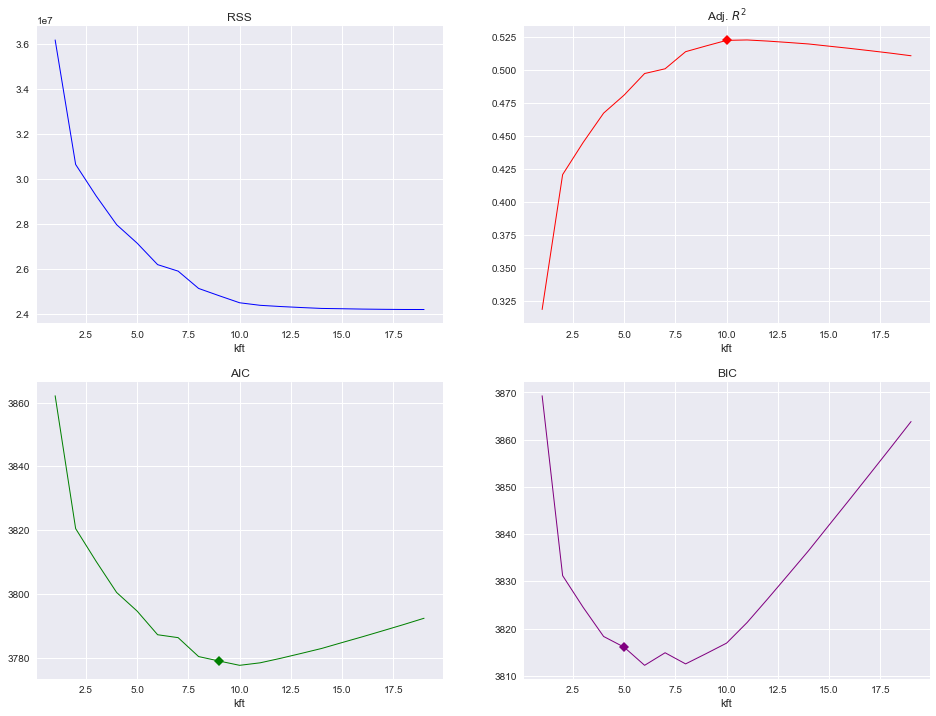

In [6]:
plt.figure(figsize=(16,12))

plt.subplot(2,2,1)
results.rss.plot(title = 'RSS',lw=1, color='blue')

plt.subplot(2,2,2)
max_r2a = results.r2a.argmax()-1
results.r2a.plot(title='Adj. $R^2$',markevery=[max_r2a],marker='D', lw=1, color='red')

plt.subplot(2,2,3)
min_aic = results.aic.argmin()-1
results.aic.plot(title='AIC',markevery=[min_aic], marker='D', lw=1, color='green')

plt.subplot(2,2,4)
min_bic = results.bic.argmin()-1
results.bic.plot(title='BIC',markevery=[min_bic], marker='D', lw=1, color='purple');

In [7]:
def processSubset(feature_set):
    model=sm.OLS(y,X[list(feature_set)])
    regr=model.fit()
    RSS=regr.ssr
    return{'model':regr,'RSS':RSS}

In [8]:
def forward(predictors):
    remaining_predictors=[p for p in X.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
        
    models = pd.DataFrame(results)
        
    best_model = models.loc[models['RSS'].argmin()]
        
    return best_model
    
def backward(predictors):
    results = []
    
    for combo in combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
        
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['RSS'].argmin()]
    
    return best_model

In [9]:
models2 = pd.DataFrame(columns=['RSS','model'])

predictors = []

for i in range(1,len(X.columns)+1):
    models2.loc[i] = forward(predictors)
    predictors = models2.loc[i]['model'].model.exog_names
    
bic_f = []

for m in models2.model:
    bic_f.append(m.bic)
    
np.array(bic_f).argmin()

5

In [10]:
predictors, bic_f

(['Hits',
  'CRBI',
  'PutOuts',
  'AtBat',
  'Division',
  'Walks',
  'CWalks',
  'CRuns',
  'CAtBat',
  'Assists',
  'Runs',
  'League',
  'HmRun',
  'Errors',
  'NewLeague',
  'RBI',
  'CHits',
  'Years',
  'CHmRun'],
 [3910.437405792022,
  3826.372838539718,
  3820.626997734044,
  3815.4605878697303,
  3810.7331322124824,
  3806.8883425646886,
  3809.8597898274984,
  3807.1870192596657,
  3809.3387521975437,
  3811.923580691154,
  3816.571399569775,
  3821.5191822804245,
  3826.8028102714034,
  3832.1077814957293,
  3837.456294954363,
  3842.8214798303275,
  3848.2258352295075,
  3853.720486189592,
  3859.2816820271046])

In [11]:
models3 = pd.DataFrame(columns=['RSS','model'],index = range(1,len(X.columns)))

predictors = X.columns

while(len(predictors)>1):
    models3.loc[len(predictors)-1]=backward(predictors)
    predictors = models3.loc[len(predictors)-1]['model'].model.exog_names
    
bic_b = []

for m in models3.model:
    bic_b.append(m.bic)
    
np.array(bic_b).argmin()

7

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=3)

In [13]:
def processSubset(feature_set,X_train,y_train,X_test,y_test):
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr=model.fit()
    RSS=((regr.predict(X_test[list(feature_set)])-y_test)** 2).sum()
    return {'model':regr,'RSS':RSS}

In [14]:
def forward(predictors,X_train,y_train,X_test,y_test):
    
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p],X_train,y_train,X_test,y_test))
        
    models = pd.DataFrame(results)
    
    best_model = models.loc[models['RSS'].argmin()]
    
    return best_model

In [15]:
models_train = pd.DataFrame(columns=['RSS','model'])

predictors = []

for i in range(1,len(X.columns)+1):
    models_train.loc[i] = forward(predictors,X_train,y_train,X_test,y_test)
    predictors = models_train.loc[i]['model'].model.exog_names

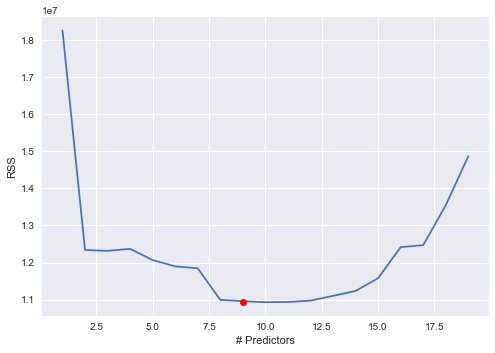

In [16]:
plt.plot(models_train['RSS'])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_train['RSS'].argmin(),models_train['RSS'].min(),'or');

In [17]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale

grid = 10 ** np.linspace(3,-2,100)

ridge_model = Ridge(normalize=True)
coefs = []

for a in grid:
    ridge_model.set_params(alpha=a)
    ridge_model.fit(X,y)
    coefs.append(ridge_model.coef_)

In [18]:
grid[49]

3.351602650938841

In [19]:
pd.Series(coefs[49], index=X.columns)

AtBat                       0.11
Hits                        0.49
HmRun                       1.32
Runs                        0.76
RBI                         0.73
                    ...         
Division                   33.63
PutOuts                     0.08
Assists                     0.01
Errors                     -0.30
NewLeague                  -5.36
Length: 19, dtype: float64

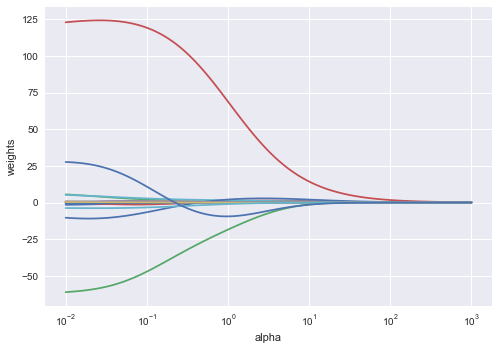

In [20]:
ax = plt.gca()
ax.plot(grid, coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [22]:
ridge2= Ridge(alpha=4, normalize=True)
ridge2_fit = ridge2.fit(X_train, y_train)
y_pred2 = ridge2.predict(X_test)

print(pd.Series(ridge2_fit.coef_, index=X.columns))
print('MSE:',mean_squared_error(y_test, y_pred2))

AtBat                       0.10
Hits                        0.45
HmRun                       1.41
Runs                        0.66
RBI                         0.84
                    ...         
Division                   30.77
PutOuts                     0.10
Assists                    -0.00
Errors                      0.27
NewLeague                  -4.12
Length: 19, dtype: float64
MSE: 106216.52238005563


In [23]:
ridge3= Ridge(alpha=1e10, normalize=True)
ridge3_fit = ridge3.fit(X_train, y_train)
y_pred3 = ridge3.predict(X_test)

print(pd.Series(ridge3_fit.coef_, index=X.columns))
print('MSE:',mean_squared_error(y_test, y_pred3))

AtBat                       0.00
Hits                        0.00
HmRun                       0.00
Runs                        0.00
RBI                         0.00
                    ...         
Division                    0.00
PutOuts                     0.00
Assists                    -0.00
Errors                      0.00
NewLeague                   0.00
Length: 19, dtype: float64
MSE: 172862.23580379886


In [24]:
ridge4= Ridge(alpha=0, normalize=True)
ridge4_fit = ridge4.fit(X_train, y_train)
y_pred4 = ridge4.predict(X_test)

print(pd.Series(ridge4_fit.coef_, index=X.columns))
print('MSE:',mean_squared_error(y_test, y_pred4))

AtBat                      -1.82
Hits                        4.26
HmRun                      -4.77
Runs                       -0.04
RBI                         3.98
                    ...         
Division                  113.74
PutOuts                     0.42
Assists                     0.46
Errors                     -6.02
NewLeague                  81.93
Length: 19, dtype: float64
MSE: 116690.46856660566


In [25]:
ridge_cv = RidgeCV(alphas=grid, normalize=True, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)
ridge_cv.alpha_

0.5857020818056667

In [26]:
ridge5= Ridge(alpha=ridge_cv.alpha_, normalize=True)
ridge5_fit = ridge5.fit(X_train, y_train)
y_pred5 = ridge5.predict(X_test)

print(pd.Series(ridge5_fit.coef_, index=X.columns))
print('MSE:',mean_squared_error(y_test, y_pred5))

AtBat                      -0.01
Hits                        0.86
HmRun                      -0.26
Runs                        0.72
RBI                         1.31
                    ...         
Division                   91.61
PutOuts                     0.28
Assists                    -0.02
Errors                     -0.30
NewLeague                  -9.99
Length: 19, dtype: float64
MSE: 99805.36301929558


In [27]:
from sklearn.preprocessing import scale
grid = 10 ** np.linspace(3,-2,100)
lasso_model = Lasso(normalize=True, max_iter=10000)
coefs = []

for a in grid:
    lasso_model.set_params(alpha=a)
    lasso_model.fit(scale(X_train),y_train)
    coefs.append(lasso_model.coef_)

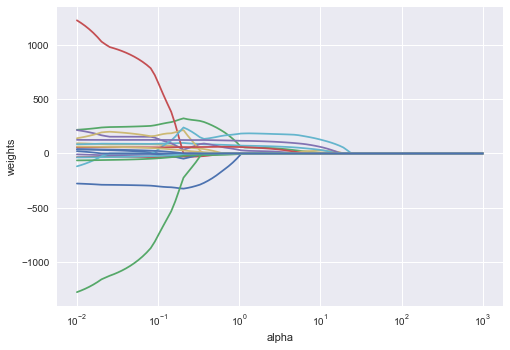

In [28]:
ax = plt.gca()
ax.plot(grid, coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');

In [29]:
lasso_cv = LassoCV(alphas=grid, max_iter=100000, normalize=True, cv=10)
lasso_cv.fit(X_train, y_train)
lasso_cv.alpha_

2.364489412645407

In [30]:
lasso2= Lasso(alpha=lasso_cv.alpha_, normalize=True, max_iter=10000)
lasso2_fit = lasso2.fit(X_train, y_train)
y_pred2 = lasso2.predict(X_test)

print(pd.Series(lasso2_fit.coef_, index=X.columns))
print('MSE:',mean_squared_error(y_test, y_pred2))

AtBat                       0.00
Hits                        1.09
HmRun                       0.00
Runs                        0.00
RBI                         0.00
                    ...         
Division                   89.91
PutOuts                     0.37
Assists                    -0.00
Errors                     -0.00
NewLeague                  -0.00
Length: 19, dtype: float64
MSE: 104933.75326714719


In [31]:
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error

In [32]:
pca = PCA()
X_pca=pca.fit_transform(scale(X))
pd.DataFrame(X_pca)

,0,1,2,3,4,5,...,13,14,15,16,17,18
0,-0.01,1.87,1.27,-0.94,1.11,1.21,...,0.39,0.06,0.14,0.08,0.04,-0.02
1,0.41,-2.43,-0.91,-0.26,1.23,1.83,...,-0.02,0.07,0.16,0.04,0.01,-0.00
2,3.47,0.83,0.56,-1.62,-0.86,-1.03,...,-0.38,0.23,0.01,-0.22,0.04,-0.07
3,-2.56,-0.23,0.52,-2.18,-0.82,1.49,...,0.03,0.04,0.05,-0.04,0.01,-0.01
4,1.03,-1.57,1.33,3.49,0.98,0.51,...,-0.09,0.04,0.01,-0.05,0.13,-0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,-0.33,-0.17,0.78,-1.54,-1.04,-0.31,...,-0.16,0.23,-0.22,0.13,-0.06,-0.01
259,3.25,-0.54,1.21,2.75,-1.20,0.83,...,0.32,-0.14,0.01,-0.15,-0.05,-0.06
260,-1.09,-0.75,-0.94,1.07,0.71,-0.64,...,0.09,0.06,-0.10,-0.08,0.07,0.01
261,1.98,-2.18,-0.28,-0.22,-0.69,3.51,...,-0.23,0.02,-0.26,-0.01,0.02,-0.01


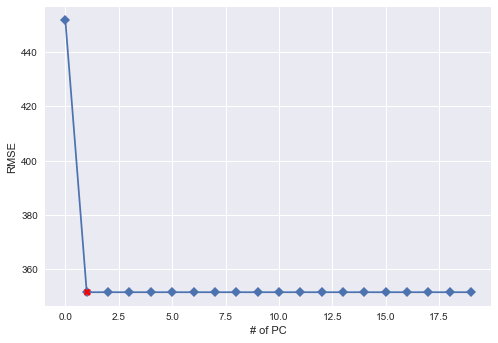

In [33]:
n=len(X_pca)
k10 = KFold(n_splits=10,shuffle=True, random_state=42)

lin_reg = LinearRegression()
rmse = []

score = -1*cross_val_score(lin_reg,np.ones((n,1)),y,cv=k10, scoring='neg_mean_squared_error').mean()
rmse.append(np.sqrt(score))

for i in np.arange(1,20):
    score = -1*cross_val_score(lin_reg,X_pca[:,:1],y,cv=k10, scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(score))
    
min_rmse = np.array(rmse).argmin()

plt.plot(rmse,'-D')
plt.plot(rmse,markevery=[min_rmse],marker='X',lw=0,color='red')
plt.xlabel('# of PC')
plt.ylabel('RMSE');

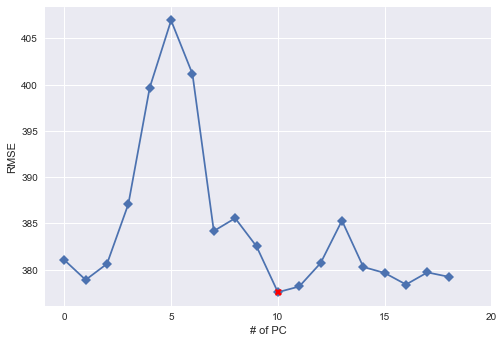

In [34]:
n=len(X_train)
k10 = KFold(n_splits=10,shuffle=True, random_state=1)

rmse = []

for i in np.arange(1,20):
    pls = PLSRegression(n_components=i)
    score = -1*cross_val_score(pls,scale(X_train),y_train,cv=k10, scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(score))
    
min_rmse = np.array(rmse).argmin()

plt.plot(rmse,'-D')
plt.plot(rmse,markevery=[min_rmse],marker='X',lw=0,color='red')
plt.xlabel('# of PC')
plt.ylabel('RMSE')
plt.xticks([0,5,10,15,20]);

In [35]:
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train),y_train)

mean_squared_error(y_test,pls.predict(scale(X_test)))

104838.51042760801